## Creation of  FITS files containing the number of events per pixel and energy bin for two cases: two point sources and one extended source 

In this notebook, I am trying to do the following: Get the spectrum of gamma rays of DM annihilation via the $b \bar{b}$ channel, for DM particle mass of $30$GeV, use a suitable binning and then create FITS files/ images containing the flux in each energy bin in two cases: two nearby point sources and one extendended sources.

Let's start. First we read from the file created using the PYTHIA simulation the columns corresponding to mass of the dark matter particle, $M_{dm}$, the quantities $\log_{10}x$ and $dN/d\log_{10} x$, where $x \equiv E/M_{dm}$ of the produced photons via the $b\bar{b}$ channel. We select and create arrays of the "energy" ($\log_{10}x$) and "spectrum" ($dN\log_{10} x$) of photons corresponding to the the selected Dark Matter mass (in GeV). We select 30 GeV, but we are free to change this.

### Part A: Binning and events number counting

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

#We open and read the file containing the spectrum. The file should be at the same directory as our script/notebook
mass, energ, bibibar = np.loadtxt("AtProduction_gammas.dat", usecols=(0,1,13), unpack=3)


#since we don't know the size of the file, let's find the length of the columns. Find the upper limit; 
#when then we are going to run a for loop, we will know the range
a = np.shape(mass)
uplim=a[0]-1

#Choose the mass of the Dark Matter particle; here 30GeV - units in the file are in GeV
mdm = 30.0

#Now, let us find how many entries have that value. We will need this number in a while.

size=0
for i in range (0,uplim):
    if (mass[i] == mdm):
        size +=1
        
#size is the number of entries corresponding to the specific value of mass. Let us create two arrays with zeros, of that size.
# The titles are logex and diendlogex, which are quite descriptive about what they contain (what they are going to contain).

logex = np.zeros(size)
diendlogex = np.zeros(size)

#Let's populate the arrays logex, diendlogex
# x=photon energy / dark matter particle mass

j = 0 
for i in range (0,uplim):
    if (mass[i] == mdm):
        logex[j] = energ[i]
        diendlogex[j] = bibibar[i]
        j +=1



In [3]:
#Remember, each array starts from zero. Useful to define the number size-1, call it n, which will serve as an upper limit

n = size -1

#just useful when we want to find the entry with the maximum index
#If we generally want to run a loop, limits 0,size are the approptiate 

Now: $\log_{10}x = \log_{10} \frac{E}{M_{dm}} = \log_{10} \frac{E}{GeV} \frac{GeV}{M_{dm}} \Rightarrow \log_{10} \frac{E}{GeV} = \log_{10}x + \log_{10} \frac{M_{dm}}{GeV} $. Since everything is expressed in GeV, is easy to create the array  
containing the logs of the energies:

In [4]:
logE = logex + np.log10(mdm) 

The other one does not require adjustment. $dN/d \log_{10} x = \ln10 x dN/dx = \ln10 \,E \, \frac{dN}{dE}$. So, remain as it is. 


In [5]:
dNdlogE = diendlogex

Now, let's get an idea of the range of energies we have. 

Print the lowest and maximum energies of photons.

In [6]:
print("minimum energy - in GeV:")
print(np.power(10,logE[0]))
print("maximum energy - in GeV:")
print(np.power(10,logE[n]))

minimum energy - in GeV:
3.77677623538e-08
maximum energy - in GeV:
30.0


We see that we get a pretty good range of energies. Of course we are interested in one more limited range of photon energies. 

We want to calculate the number of counts for a number of (logarithmic bins).

Denote $b = dN / d\log_{10} E$. Thus, in a bin :

\begin{equation}
N = time \times \int_{\log E_{low}}^{\log E_{up}} \frac{dN}{d\log E} A_{eff}(\log E)  d\log E
\end{equation}

Since we have to multiply by the total exposure time and also in the integration we have to take into account the $A_{eff}(E)$ (integrate over it).

In [7]:
#energies, bins from 0, size 


#Let's choose energies of photons. Remember energy is given in Gev

#Starting energy of photons in GeV

Est = 0.01

#Maximum energy = equal to the dark matter mass

Eend = mdm

#Since we work in log space, let's define their logarithms

logstart = np.log10(Est)
logend = np.log10(Eend)

#Now, define the number length of logarithmic step. Let's take it equal to 1/5
#This is the inverse of the number of bins per decade

logstep = 1.0/5.0 

#Let's find the number of energy bins:

numbins = int((logend-logstart)/logstep)+1

print(numbins)

#Create empty array, with number of entries equal to the number of bins, which we are going to populate

counts = np.zeros(numbins)


# We will also need the Effective area of the fermiLAT 
#In the following Aenerg is the energy -warning it is given in Mev- and Aeff the effective energy (in M^2)


Aenerg, Aeff = np.loadtxt("A_eff_Fermi.dat", usecols=(0,1), unpack=3)


#Now the energy is given in MeV. We need to convert this in GeV and also we need actually its logarithm
#define logAenerg

logAenerg = np.log10(Aenerg/1000.0)

#Thus, Aeff is now function of the log of the energy 

# Aeff in m^2, let's convert in cm^2 by multiplying 

Aeff = Aeff*10000


#Let's now use interpolation in order to have a value corresponding to dN/dlogE for every
#Also a interpolation in order to get a value for every energy for Aeff

from scipy import interpolate

intrpdNdlogE = interpolate.interp1d(logE, dNdlogE)
intrpAeff = interpolate.interp1d(logAenerg, Aeff)


#Function which implements a trapezoidal rule integration
#For the integrated function, see above 

def integralino(a,b):
    #Number of points
    nu = 1000
    #step 
    h = (b - a)/nu
    summa = 0.0
    for j in range (0,nu):
        x1 = a + j*h
        x2 = x1 + h
        q1 = (intrpdNdlogE(x1))*(intrpAeff(x1))
        q2 = (intrpdNdlogE(x2))*(intrpAeff(x2))
        summa = summa +  q1 + q2
    summa = summa*h/2.0
    return summa


#So, we now have an array with as many cells as the number of energy bins. Let's populate them.
# We will also need total exposure time

years=10
frac_year = 0.2
sec_year = 365*24*3600 

#exposure time

texp = years*frac_year*sec_year


 

#We have also to introduce a normalization factor

norm = 2.87e-10/2.0

 

for i in range (0,numbins):
    ll = logstart + i*logstep         #upper limit of the energy bin
    ul = logstart + (i+1)*logstep     #lower limit of the energy bin
    if (ul > logend):                 #special case, accounts for the last cell
        ul = logend
    counts[i] = norm*texp*integralino(ll, ul)

# Erase the comment symbol in order to see the number of counts
print(counts)



18
[  6.61585711e-02   7.80621364e-01   4.69926188e+00   1.73903327e+01
   4.52763984e+01   9.17838747e+01   1.52659050e+02   2.07377794e+02
   2.21957919e+02   2.10950719e+02   1.69923737e+02   1.12038922e+02
   5.81798957e+01   2.21157775e+01   6.19457564e+00   1.18248637e+00
   1.27943281e-01   7.78919522e-03]


## Creation of FITS files


### Case 1 - Two point sources

In [8]:
#First, let's state the coordinates of the two sources, latitde and longitude
#in galactic coordinates
#longitude in l, latitude in b
# longitude is the x-like coordinate, latitude is the y-like coordinate

#source1 is J221251+064604
#source2 is J221408+071128

source1l = 68.52764
source1b = -38.81095

source2l = 69.20910
source2b = -38.75225

#define angular length of each side of the bin

binln = 0.05

#we want a 20*20 degrees box

leng = int(20.0/binln)

#create 3d array, with the appropriate angular size and number of bins corresponding to the energy bins

twosources = np.zeros((numbins,leng,leng))

#Now, let's make a choice for the coordinates of the upper left point 
#We define it to be 10 degrees of in each direction 

upx = (source1l+source2l)/2.0 + 10.0 
upy = (source2b+source2b)/2.0 + 10


#Find and the other limits

lowx = upx - 20.0
lowy = upy - 20.0

#find now the pixel positions of the two points

def pixelposx(x,ux,binln):
    posx = int((ux - x)/binln)
    return posx


def pixelposy(y,uy,binln):
    posy = int((uy - y)/binln)
    return posy


 
    
pospix1x = pixelposx(source1l,upx,binln) 
pospix1y = pixelposy(source1b,upy,binln)
pospix2x = pixelposx(source2l,upx,binln) 
pospix2y = pixelposy(source2b,upy,binln) 


#Ready to populate the array

for i in range (0,numbins):
    twosources[i][pospix1y][pospix1x] = counts[i]
    twosources[i][pospix2y][pospix2x] = counts[i]
    



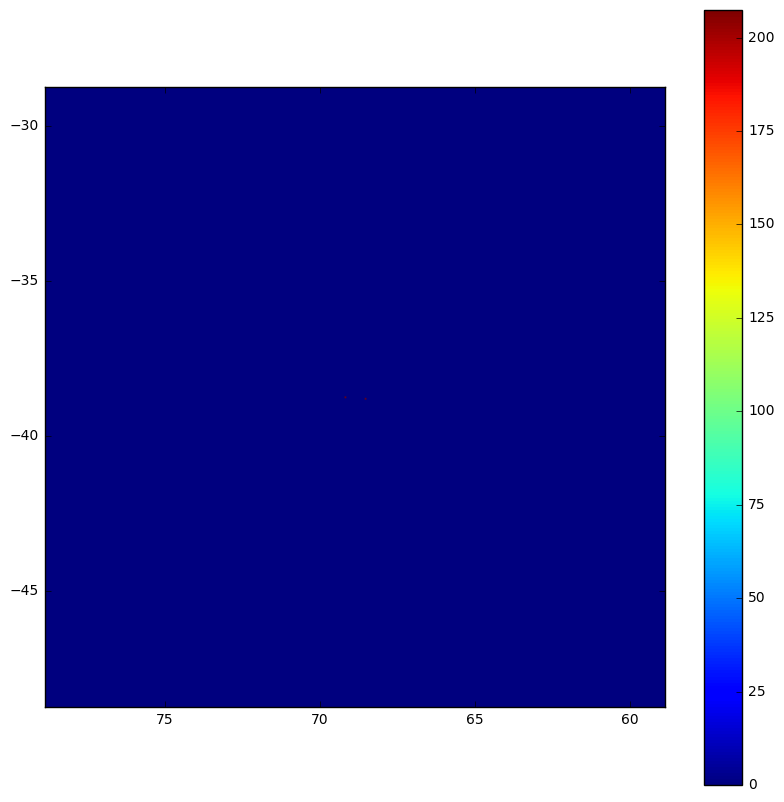

In [9]:
from astropy.io import fits

hdu = fits.PrimaryHDU()
hdu.data=twosources

hdu.writeto('twosources.fits', clobber = True)

fig=plt.figure(figsize=(10.0, 10.0))
plt.imshow(hdu.data[7], extent=[upx,lowx,lowy,upy])
plt.autoscale(False)
plt.xlim(upx,lowx)
plt.ylim(lowy,upy)

plt.colorbar()


### Case 2 - An extended source 

Extended source at the center of the grid, gaussian distribution of counts:
\begin{equation}
N \sim e^{-\frac{1}{2}\frac{x^2+y^2}{\sigma^2}}
\end{equation}
with  $\sigma = 0.25^\circ$.

In [10]:
#create again an empty 3d array - a 20x20 degrees box 

extsource = np.zeros((numbins,leng,leng))

#define std deviation 

sigma = 0.25

#The array is a 400*400 arrray - it has no central point. Instead we will define four central points 
#define the coordinates of the four four central points. Define the points as lr = low right, ll = low left, ur = upper right
#ul = upper left. A simple diagram would be very helpful here. 
#i is row, j is column

adef = int(leng/2.0)



lri = adef; lrj = adef
lli = adef; llj = adef - 1
uri = adef - 1; urj = adef
uli = adef -1; ulj = adef - 1




#the following function finds the quarter of the grid 
# named again ll, lr, ur, ul  


def quarter(i,j):
    if ((i >= lri) and (j >= lrj)):
        quarto = "lr"
    elif ((i >= lli) and (j <= llj)):
        quarto = "ll"
    elif ((i <= uri) and (j >= urj)):
        quarto = "ur"
    elif ((i <= uli) and (j <= ulj)):
        quarto = "ul"
    return quarto


#the following function calculates and returns the value as calculated from a 2d gaussian distribution 

def gaussian(a,b,i,j):
    forx = abs(j - b)*binln + (binln/2.0)
    fory = abs(i - a)*binln + (binln/2.0)
    exponent = - (forx**2.0 + fory**2.0)/(2.0*(sigma**2.0))
    value = np.exp(exponent)
    return value 
    




#populate the array
#energies will run in k 
#keep track of the total value of entries in each slice in order to normalize 

norma = 0.0
for k in range (0,numbins):
    for i in range (0, leng):
        for j in range (0, leng):
            quar = quarter(i,j)
            if (quar == "lr"):
                entry = gaussian(lri,lrj,i,j)
            elif (quar == "ll"):
                entry = gaussian(lli,llj,i,j)
            elif (quar == "ur" ):
                entry = gaussian(uri,urj,i,j)
            elif (quar == "ul"):
                entry = gaussian(uli,ulj,i,j)
            extsource[k][i][j]= entry
            if (k == 0):
                norma = norma + entry 
                
                
#Normalize now the array and multiply by the number of counts per energy bin

for k in range (0, numbins):
    extsource[k] = (2.0*counts[k])*extsource[k]/norma


    
    


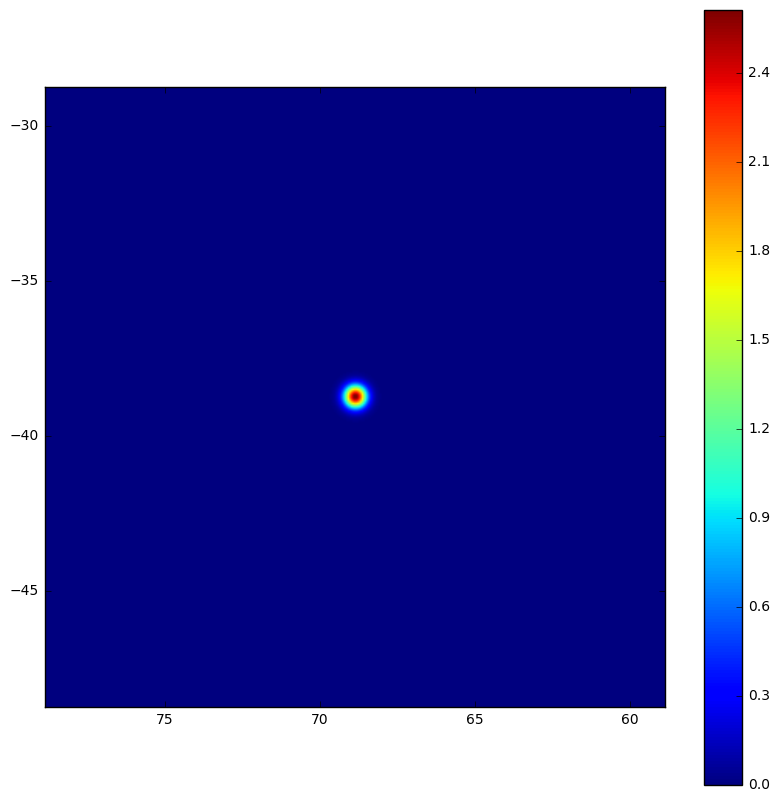

In [11]:
hdu1 = fits.PrimaryHDU()
hdu1.data=extsource

hdu1.writeto('extended.fits', clobber = True)

fig=plt.figure(figsize=(10.0, 10.0))
plt.imshow(hdu1.data[7], extent=[upx,lowx,lowy,upy])
plt.autoscale(False)
plt.xlim(upx,lowx)
plt.ylim(lowy,upy)

plt.colorbar()

